#Install Required Libraries:

In [ ]:
!pip install pandas scikit-learn tensorflow matplotlib seaborn

#Load the Dataset

In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/user_behavior_dataset.csv')

# Display the first few rows to confirm it loaded correctly
print(data.head())


   User ID    Device Model Operating System  App Usage Time (min/day)  \
0        1  Google Pixel 5          Android                       393   
1        2       OnePlus 9          Android                       268   
2        3    Xiaomi Mi 11          Android                       154   
3        4  Google Pixel 5          Android                       239   
4        5       iPhone 12              iOS                       187   

   Screen On Time (hours/day)  Battery Drain (mAh/day)  \
0                         6.4                     1872   
1                         4.7                     1331   
2                         4.0                      761   
3                         4.8                     1676   
4                         4.3                     1367   

   Number of Apps Installed  Data Usage (MB/day)  Age  Gender  \
0                        67                 1122   40    Male   
1                        42                  944   47  Female   
2                

#Data Processing

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Select relevant numerical features for time-series analysis
features = ['App Usage Time (min/day)', 'Screen On Time (hours/day)',
            'Battery Drain (mAh/day)', 'Data Usage (MB/day)']

# Scale the features using MinMaxScaler for LSTM compatibility
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

print(f"Scaled Data Shape: {scaled_data.shape}")


Scaled Data Shape: (700, 4)


#Create Time-Series Data for LSTM

In [ ]:
import numpy as np

# Function to create time-series sequences
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        sequences.append(seq)
    return np.array(sequences)

# Define sequence length (e.g., 10 days)
sequence_length = 10
X = create_sequences(scaled_data, sequence_length)

print(f"Shape of Time-Series Data: {X.shape}")  # (num_sequences, sequence_length, num_features)


Shape of Time-Series Data: (690, 10, 4)


#Build and Train LSTM Autoencoder for Anomaly Detection

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

# Define LSTM Autoencoder Model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, len(features)), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(sequence_length),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(len(features)))
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(X, X, epochs=50, batch_size=32, validation_split=0.1, shuffle=False)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 10, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 10, 32)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 10, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 10, 4)               │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,492 (248.02 KB)

 Trainable params: 63,492 (248.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 339ms/step - loss: 0.2374 - val_loss: 0.1246
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1377 - val_loss: 0.1041
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1173 - val_loss: 0.0949
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1055 - val_loss: 0.0849
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0934 - val_loss: 0.0810
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0875 - val_loss: 0.0773
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0825 - val_loss: 0.0747
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0798 - val_loss: 0.0745
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0790 - val_loss: 0.0733
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0780 - val_loss: 0.0726
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0771 - val_loss: 0.0717
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0756 

#Plot Training and Validation Loss

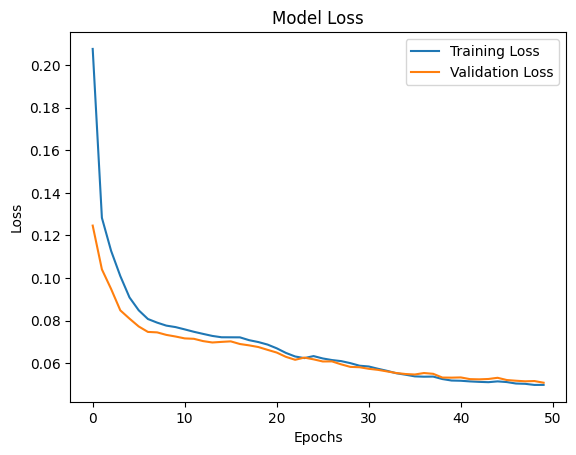

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#Detect Anomalies Using Reconstruction Error

In [ ]:
# Make predictions (reconstructed sequences)
X_pred = model.predict(X)

# Calculate reconstruction error
reconstruction_error = np.mean(np.abs(X_pred - X), axis=(1, 2))

# Set a threshold for anomaly detection (e.g., 95th percentile)
threshold = np.percentile(reconstruction_error, 95)
print(f"Anomaly Detection Threshold: {threshold}")

# Identify anomalies
anomalies = reconstruction_error > threshold
print(f"Number of Anomalies Detected: {np.sum(anomalies)}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step
Anomaly Detection Threshold: 0.252820874476688
Number of Anomalies Detected: 35


#Visualize Anomalies

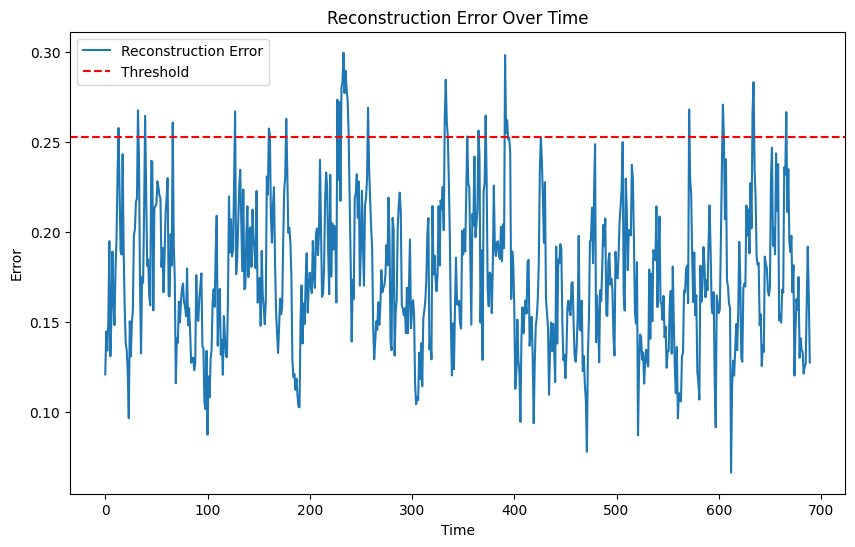

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(reconstruction_error, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Over Time')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.show()
